# Validation of method

### Table of contents

1. [**Building the model**](#build)
3. [**Generating synthetic data**](#gen)
4. [**Model recovery**](#fit)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])

<a id='build'></a>
## Building the model

In [24]:
def get_stat_model(mu, lsigma, log_beta, log_gamma, len_x, kernel_class, neurons):
    """
    """
    f_dims = neurons
    x_dims = f_dims
    
    v_t = 1.*np.ones(neurons)
    v_r = -.3*np.ones(neurons)
    tau_m = 0.01*np.ones(neurons)
    tau_s = np.ones(neurons)
    log_beta = log_beta*np.ones(neurons)
    log_gamma = log_gamma*np.ones(neurons)
    
    tau_h = 0.1*np.ones(neurons)
    a = 1.0*np.ones(neurons)
    b = 1000.0*np.ones(neurons)

    IF_model = lib.IF_models.LIF(log_beta, log_gamma, v_t, v_r, tau_s, tau_m)#, tau_h, a, b)
    
    eps_mapping = lib.mappings.Identity(f_dims)

    ### state space GP ###
    var_x = 1.0*np.ones(x_dims)  # GP variance
    len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

    kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
    #kernx = lib.kernels.IID(jnp.eye(x_dims))
    
    state_space = lib.state_space.FullLDS(kernx, diagonal_site=True)

    ### mu and sigma ###
    params = {'value': mu*jnp.ones((f_dims,))}
    mu_mapping = lib.mappings.Constant(x_dims, f_dims, params)

    params = {'value': lsigma*jnp.ones((f_dims,))}
    lsigma_mapping = lib.mappings.Constant(x_dims, f_dims, params)
    
    ### initial conditions ###
    q_vh_ic = jnp.zeros((num_samps, neurons, IF_model.q_d))
    
    ### IF GP model ###
    model = lib.inference.IF_SSGP(
        state_space, eps_mapping, mu_mapping, lsigma_mapping, IF_model, q_vh_ic, dtype=jnp.float64)
    return model

<a id='gen'></a>
## Generate synthetic data

In [91]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

model = get_stat_model(
    0.1, -0.5, 3., 3., 0.01, lib.kernels.Matern12, neurons)


Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
y = np.zeros((t.shape[0], neurons))
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)

In [92]:
spiketrains, q_vh, I, eps_samples = model.sample_prior_spikes(
    prng_state, num_samps, x_obs=None, timedata=None)


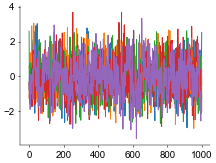

In [93]:
for n in range(num_samps):
    plt.plot(eps_samples[:, n, 1])
             
plt.show()

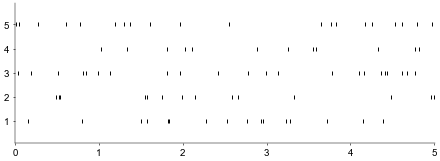

In [94]:
fig = plt.figure(figsize=(6, 2))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, 
                         height_ratios=heights, top=1.0, bottom=0.0, left=.0, right=1.0)

ax = fig.add_subplot(spec[0, 0])
    
lib.plots.raster_plot((fig, ax), spiketrains[:, :, 0].T, 
                     time_bins=Tsteps, bin_time=model.dt[1], units=num_samps, colors=None, marker='|', markersize=10)

plt.show()

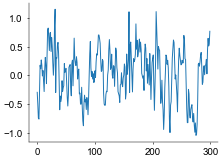

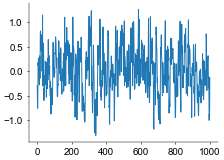

In [95]:
plt.plot(q_vh[:300, 0, 0, 0])
plt.show()

plt.plot(q_vh[:, 0, 0, 1])
plt.show()

<a id='fit'></a>
## Model recovery

In [109]:
neurons = 2
num_samps = 5
prng_state = jax.random.PRNGKey(123)

model = get_stat_model(
    0.0, 0.0, 2., 2., 0.1, lib.kernels.Matern12, neurons)


Tsteps = 1000
t = np.linspace(0., 5., Tsteps)  # s
x_obs = jnp.empty((t.shape[0], 1, 0))
tr = 0
y = np.array(spiketrains[:, tr, :])
#mask = np.ones_like(y).astype(bool)
#mask[:, 0] = False
mask = None
model.set_data(t, x_obs, y, mask=mask)



model.state_space.normal_site_init(model.t.shape[0], std=1.0)
model.state_space.var_params['site_obs'] = model.state_space.var_params['site_obs'].at[500, :, 0].set(0.)

In [110]:
learning_rate_schedule = optax.exponential_decay(
    init_value=1e-2, transition_steps=20, decay_rate=0.9, 
    transition_begin=0, staircase=True, end_value=None
)

optim = optax.adam(learning_rate_schedule)

In [111]:
def split_all_params_func(all_params):
    
    learned = lib.utils.copy_pytree(all_params)
    learned['hyp']['IF_model']['v_t'] = None
    learned['hyp']['IF_model']['v_r'] = None
    #learned['hyp']['IF_model']['log_beta'] = None
    #learned['hyp']['IF_model']['log_gamma'] = None
    fixed = jax.tree_map(lambda x: None, all_params)
    fixed['hyp']['IF_model']['v_t'] = all_params['hyp']['IF_model']['v_t']
    fixed['hyp']['IF_model']['v_r'] = all_params['hyp']['IF_model']['v_r']
    #fixed['hyp']['IF_model']['log_beta'] = all_params['hyp']['IF_model']['log_beta']
    #fixed['hyp']['IF_model']['log_gamma'] = all_params['hyp']['IF_model']['log_gamma']

    return learned, fixed


In [112]:
plot_intermediate = False
print_every = 10
epochs = 500


all_params = model.get_all_params()
opt_state = optim.init(all_params)

loss_tracker = []
for j in range(epochs):
    
    loss, grads = model.train_ELBO(all_params, prng_state, num_samps, 
                                   split_all_params_func, take_grads=True)
    print(loss)
    
    # gradient step
    updates, opt_state = optim.update(grads, opt_state)
    all_params = optax.apply_updates(all_params, updates)
    all_params = model.constraints(all_params)
    
    prng_state, _ = jr.split(prng_state)
    
    loss_tracker.append(loss)

347.5414656383447
330.2101424976272
323.7870295776181
319.60441268531895
316.3046068745768
312.8223379014687
309.52407919008056
306.35624030486315
303.04242113512237
300.00540769656254
297.0987073654733
294.0960765913865
291.1587495834773
288.33006871704794
285.6303638240249
282.7468167935948
279.8930026083275
277.27842010846047
274.4982179388216
271.923411795314
269.2680468485095
267.0316669205186
264.7259283844455
262.4724571570044
260.2761755602917
258.1684045485417
255.8619364012494
254.002622763573
251.68853738677586
249.88949131559286
247.83533511147482
245.74754860794766
243.86321773636632
241.82441427346038
239.9045243752388
237.9443648661914
236.00229791907557
234.08636559279648
232.53157872726263
230.47260285111352
228.99147494611518
227.39242698552434
225.83253567273283
224.16306060297947
222.68958060245137
221.14393768727993
219.83245644232082
218.42116323980179
216.77702667556196
215.54612512068132
213.89357325324437
212.59722626273876
211.19641495999468
209.86800402273204

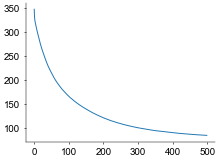

In [113]:
plt.plot(loss_tracker)

In [114]:
model.set_all_params(all_params)  # set new model parameters

In [115]:
model.IF_model.params

{'log_beta': DeviceArray([1.96359624, 1.962971  ], dtype=float64),
 'log_gamma': DeviceArray([0.62920215, 0.63002833], dtype=float64),
 'tau_m': DeviceArray([0.00694127, 0.00688686], dtype=float64),
 'tau_s': DeviceArray([1., 1.], dtype=float64),
 'v_r': DeviceArray([-0.3, -0.3], dtype=float64),
 'v_t': DeviceArray([1., 1.], dtype=float64)}

In [116]:
all_params

{'hyp': {'IF_model': {'log_beta': DeviceArray([1.96359624, 1.962971  ], dtype=float64),
   'log_gamma': DeviceArray([0.62920215, 0.63002833], dtype=float64),
   'tau_m': DeviceArray([0.00694127, 0.00688686], dtype=float64),
   'tau_s': DeviceArray([1., 1.], dtype=float64),
   'v_r': DeviceArray([-0.3, -0.3], dtype=float64),
   'v_t': DeviceArray([1., 1.], dtype=float64)},
  'eps_mapping': {},
  'ic': DeviceArray([[[-1.13357429],
                [-1.18084182]],
  
               [[-1.09797717],
                [-1.38525354]],
  
               [[-1.15651047],
                [-1.29187711]],
  
               [[-1.10172422],
                [-1.3443614 ]],
  
               [[-1.16440337],
                [-1.30868106]]], dtype=float64),
  'lsigma_mapping': {'value': DeviceArray([0.57293694, 0.55069517], dtype=float64)},
  'mu_mapping': {'value': DeviceArray([-0.81691319, -0.81133502], dtype=float64)},
  'state_space': {'kernel': {'lengthscale': DeviceArray([[-1.55567975],
              

<a id='analysis'></a>
## Analysis

In [117]:
spiketrains, q_vh, I, eps_samples = model.sample_posterior_spikes(prng_state, num_samps)

In [118]:
t_eval = np.linspace(-2., 7., 100)  # s
timedata = (model.t, model.dt)

post_mean, post_cov, _ = model.state_space.evaluate_posterior(
    t_eval, timedata, model.state_space.params, model.state_space.var_params, 
    mean_only=False, compute_KL=False, jitter=1e-8)
post_mean = post_mean[..., 0]

evaldata = lib.state_space.get_evaldata(t_eval, timedata)
post_samples, _ = model.state_space.sample_posterior(
    model.state_space.params, model.state_space.var_params, prng_state, 100, 
    timedata, evaldata, jitter=1e-8, compute_KL=False)


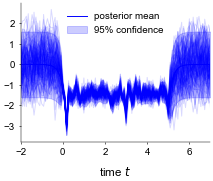

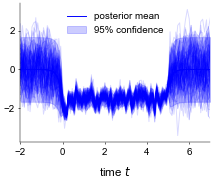

In [119]:
post_var = post_cov[:, np.arange(model.x_dims), np.arange(model.x_dims)]
lb = post_mean - 1.96 * post_var ** 0.5
ub = post_mean + 1.96 * post_var ** 0.5

for plot_out in range(model.f_dims):
    plt.figure()
    plt.plot(t_eval, post_mean[:, plot_out], 'b', label='posterior mean')
    plt.fill_between(t_eval, lb[:, plot_out], ub[:, plot_out], color='b', alpha=0.2, label='95% confidence')
    plt.plot(t_eval, post_samples[..., plot_out, 0], 'b', alpha=0.15)
    plt.xlim([t_eval[0], t_eval[-1]])
    plt.legend()
    plt.xlabel('time $t$')
    plt.show()

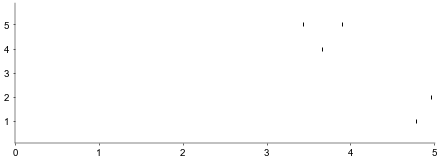

In [120]:
fig = plt.figure(figsize=(6, 2))

widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, 
                         height_ratios=heights, top=1.0, bottom=0.0, left=.0, right=1.0)

ax = fig.add_subplot(spec[0, 0])
    
lib.plots.raster_plot((fig, ax), spiketrains[:, :, 0].T, 
                     time_bins=Tsteps, bin_time=model.dt[1], units=num_samps, colors=None, marker='|', markersize=10)

plt.show()

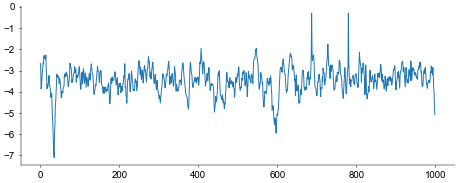

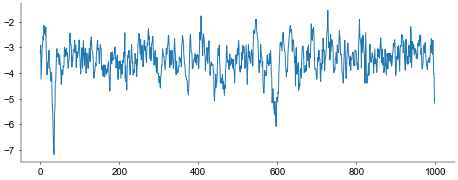

In [121]:
tr, n = 4, 0

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(q_vh[:, tr, n, 0])
plt.show()


fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(I[:1000, tr, n])
plt.show()

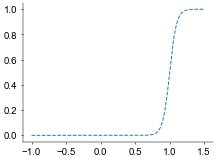

In [64]:
import matplotlib.pyplot as plt
from jax import vmap, grad

t = jnp.linspace(-1., 1.5, 1000)
sg_beta = jnp.exp(3.)
l = sg_beta / jnp.exp(3.)
t_t = 1.
softpl = jax.nn.softplus(-sg_beta*(t-t_t))

pr = np.exp(-softpl / l)


#plt.plot(t, lib.IF_models.heaviside(t, sg_beta))
plt.plot(t, pr, '--')
#plt.plot(t, sg_beta*vmap(grad(heaviside))(sg_beta*t))
#plt.plot(t, sg_beta*vmap(grad(jax.nn.sigmoid))(sg_beta*t), '--')
plt.show()

In [27]:
def make_T(n, a, b, c):
    # Create a psuedo-random tridiagonal Jacobian and store band
    T = jnp.zeros((n, n), dtype=jnp.float32)
    T = T.at[jnp.arange(n-1), jnp.arange(n-1)+1].set(a)
    T = T.at[jnp.arange(n), jnp.arange(n)].set(b)
    T = T.at[jnp.arange(n-1)+1, jnp.arange(n-1)].set(c)
    return T

In [55]:
T = make_T(21, 0.5, 1., 0.5)
eigval, eigvec = jnp.linalg.eig(T)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


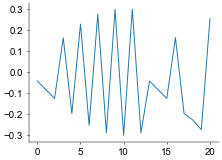

In [57]:
plt.plot(eigvec[0, :])

In [54]:
jnp.real(eigval)

DeviceArray([0.98020405, 0.98081064, 0.9818082 , 0.98317546, 0.9848846 ,
             0.9869025 , 0.98918664, 0.9916916 , 0.99436426, 0.99715406,
             0.99999976, 1.0197967 , 1.0191902 , 1.0181915 , 1.016825  ,
             1.0151157 , 1.0028456 , 1.005635  , 1.0130972 , 1.0083079 ,
             1.010813  ], dtype=float32)

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


import pickle

import sys
sys.path.append("../../neuroppl/")
sys.path.append("..")
sys.path.append("../scripts/")


import neuroppl as nppl
from neuroppl import utils


import matplotlib.pyplot as plt

import os
if not os.path.exists('./saves'):
    os.makedirs('./saves')


import pickle


import lib
import synthetic


gpu_dev = 0
dev = utils.pytorch.get_device(gpu_dev)
plt.style.use(['paper.mplstyle'])

In [17]:
# data
checkpoint_dir = '../scripts/checkpoint/'
datatype = 1

single_spikes = False
bin_size = 500

dataset_tuple = synthetic.get_dataset(datatype)
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple
#region_edge = metainfo[0]

# model
ll_mode = 'IPPexp'
filt_mode = ''
map_mode = 'svgp32'
x_mode = 'hd-isi1'
z_mode = ''
hist_len = 0
folds = 5
delays = [0]
m = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

# load
cv_run = -1
delay = 0
batch_size = 5000

inputs_used = lambda *args: synthetic.inputs_used_(datatype, *args)
enc_used = lambda *args: synthetic.enc_used_(datatype, *args)

modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, m, dataset_tuple, inputs_used, enc_used, 
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5, J=100
)

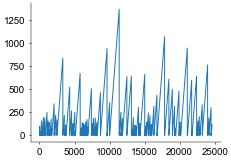

In [19]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple

plt.plot(rcov[1][2, :, 0])

In [78]:
steps = 1000
covariates = [torch.linspace(0, 2*np.pi, steps)*0, torch.linspace(0, 1000.0, steps)]

use_neuron = [0, 1, 2]
trials = 1

cov = modelfit.mapping.to_XZ(covariates, trials)
with torch.no_grad():
    F_mu, F_var = modelfit.mapping.compute_F(cov)


with torch.no_grad():
    modelfit.mapping.jitter = 1e-4
    mc = 10
    eps = torch.randn(mc, 50, 1000, device=modelfit.mapping.dummy.device)
    F = modelfit.mapping.sample_F(cov, eps)

In [79]:
modelfit.mapping.kernel.kern1

DeepKernel(
  (kern): RBF()
  (map): time_transform()
)

In [80]:
x = torch.exp(F)
p = x*torch.exp(-torch.cumsum(x, dim=-1)*0.001)

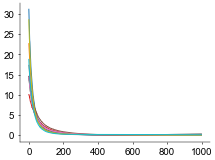

In [90]:
plt.plot(p[:, 26, :].cpu().numpy().T)
plt.show()

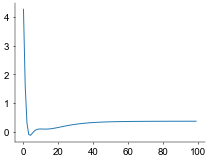

In [28]:
n = 3
fm = F_mu.cpu().numpy()[0, n, :]

plt.plot(fm)

In [32]:
x = np.exp(fm)
p = x*np.exp(-np.cumsum(x, axis=1)*dt) # natural time

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
tau = np.arange(Tl)*dt
tau_0 = 0.001
t = tau_0*(np.exp(tau) - 1)
dtau_dt = 1/(t+tau_0)

In [ ]:
(p*dt).sum(1)